# Testing the constant-longitude, constant-time case

#### TL;DR It actually sort-of works

## Import useful packages

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

## Define functions to load the data

In [0]:
def load_image(image_path, dim=(224,224)):
  """
  Loads a single image as a Numpy array and resizes it as
  desired.  The default dimensions are consistent with
  those expected by the VGG models.  

  Args:
    image_path: str pointing to the file

    dim: Two-element tuple giving the desired height
         and width of the processed image

  Returns:
    image:  A single-channel Numpy array
    """
  image = cv2.imread(image_path, 0)
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return image

In [0]:
def build_input(image_dir):
  """
  Loads all of the images into a single numpy array.
  Assumes that there are 101 equally-spaced images
  spanning lattitudes from 35N to 45N.  

  Args:
    image_dir: str giving name of the image directory

  Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.
    
    y:  A 1-dimensional numpy array of target lattitudes.
    """
  X = []
  y = np.arange(35, 45.01, step=0.1)
  for i in range(101):
    file_name = 'image' + str(i) + '.png'
    image_path = os.path.join(image_dir, file_name)
    image = load_image(image_path)
    X.append(image)
  return (np.array(X) / 255, y)

(224, 224)


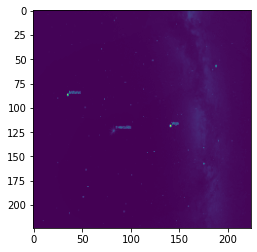

In [4]:
sample_image = load_image('/content/image19.png')
plt.imshow(sample_image)
print(sample_image.shape)

## Prepare the data

### Load the images

In [0]:
X, y = build_input("/content")
y = y / 40

### Split into test and training sets

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(80, 224, 224)
(80,)
(21, 224, 224)
(21,)


## The model

We can probably prune this back a bit.  This is simply a DNN with single layer output suitable for regression.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              51381248  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6

I put the barest effort into choosing an optimizer and learning rate.  We can probably do better.

In [0]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

In [0]:
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

`callbacks` can be used to tell the model when to stop training.  In this case, I'm having it stop if the mean squared error hasn't improved for 20 epochs.

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=20)

Fit the model.

In [12]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
                    verbose=2, epochs=200, callbacks=[callback])

Epoch 1/200
3/3 - 0s - loss: 0.9749 - mean_squared_error: 0.9749 - val_loss: 0.9744 - val_mean_squared_error: 0.9744
Epoch 2/200
3/3 - 0s - loss: 0.8968 - mean_squared_error: 0.8968 - val_loss: 0.8936 - val_mean_squared_error: 0.8936
Epoch 3/200
3/3 - 0s - loss: 0.8182 - mean_squared_error: 0.8182 - val_loss: 0.8124 - val_mean_squared_error: 0.8124
Epoch 4/200
3/3 - 0s - loss: 0.7410 - mean_squared_error: 0.7410 - val_loss: 0.7353 - val_mean_squared_error: 0.7353
Epoch 5/200
3/3 - 0s - loss: 0.6650 - mean_squared_error: 0.6650 - val_loss: 0.6582 - val_mean_squared_error: 0.6582
Epoch 6/200
3/3 - 0s - loss: 0.5907 - mean_squared_error: 0.5907 - val_loss: 0.5744 - val_mean_squared_error: 0.5744
Epoch 7/200
3/3 - 0s - loss: 0.5108 - mean_squared_error: 0.5108 - val_loss: 0.4924 - val_mean_squared_error: 0.4924
Epoch 8/200
3/3 - 0s - loss: 0.4335 - mean_squared_error: 0.4335 - val_loss: 0.4152 - val_mean_squared_error: 0.4152
Epoch 9/200
3/3 - 0s - loss: 0.3585 - mean_squared_error: 0.3585

### Evaluate model performance

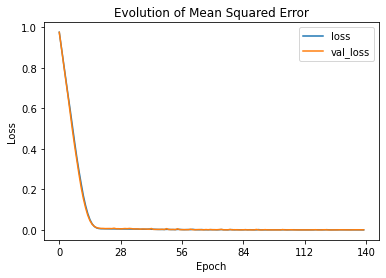

In [13]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [0]:
y_hat = model.predict(X_val)

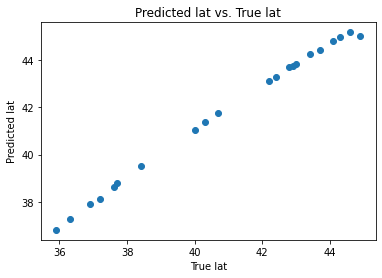

In [15]:
plt.scatter(y_val * 40, y_hat * 40)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()